In [5]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])
grads = K.gradients(loss, model.input)[0] # only keep first tensor
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [6]:
iterate = K.function([model.input], [loss, grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [7]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [12]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    grads /= K.sqrt(K.mean(K.square(grads)) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

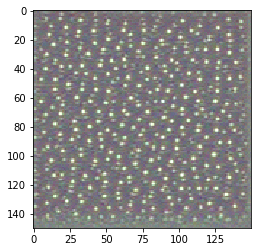

In [13]:
import matplotlib.pyplot as plt
plt.imshow(generate_pattern('block3_conv1', 0))

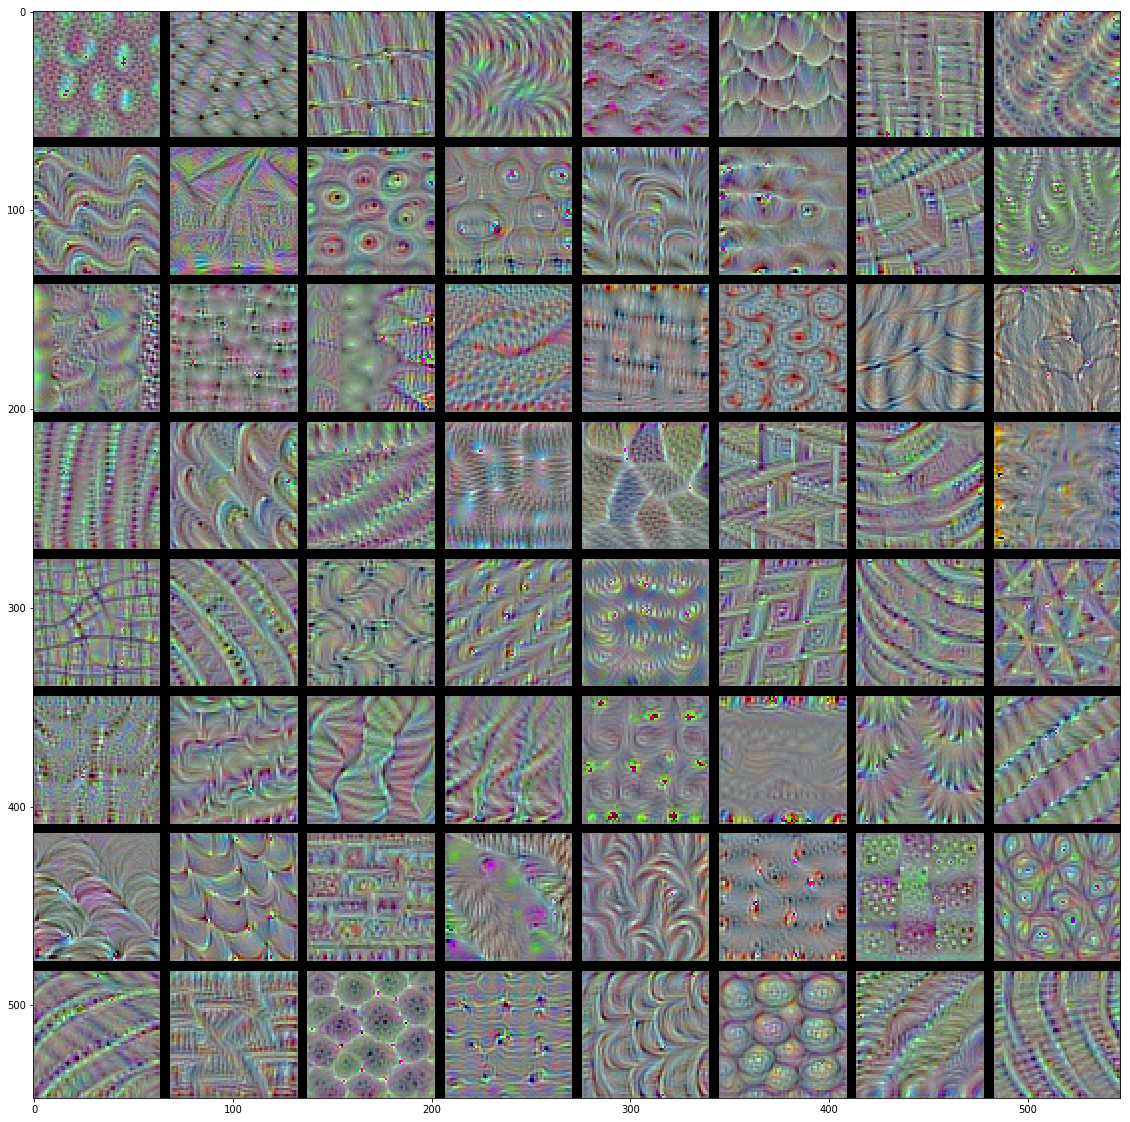

In [21]:
layer_name = 'block4_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start : horizontal_end, vertical_start : vertical_end] = filter_img

plt.figure(figsize=(20, 20))
plt.imshow(results)